In [1]:
###############################################################################
# OPTIMIZATION & AI - LAB 02
# LOVITON Pierre
###############################################################################

In [160]:
# System imports
import matplotlib.pyplot as plt
import numpy as np

#Extra library imports
import pandas as pd
from scipy.optimize import minimize, optimize
import seaborn as sns

In [3]:
# User inputs
color_dict = {'benign': 'g', 'malignant': 'r'}
csvpath = 'breats_cells.csv'

Breast cancer is the most common cancer among women in France, and also the leading cause of cancer death in women. If the presence of a lesion is suspected after a breast cancer screening, the diagnosis can be confirmed performing a biopsy, i.e. the extraction of a sample of the abnormal tissue on the patient. The analysis of the collected sample using microscopic techniques allows detecting malignant breast cells, that differ from healthy cells in features such as shape, density or size. In this lab, we will more especially focus on the circularity of breast cells, to study if it is a potential tumor marker. 

# I. Linear regression on breast cells' features using gradient descent

## a) Exploration of  the dataset

We will now study the breast cancer wisconsin dataset, collecting features on healthy and malignant cells. You may find additional information about this dataset on https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic).

<font color='blue'> Question 1: load the dataset in the 'breast_csv' file using pandas. Compute automatically and display the number of samples and potential features in this dataset using the shape attribute of pandas.</font>

In [11]:
df = pd.read_csv(csvpath)

In [12]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,10.570,18.32,66.82,340.9,0.08142,0.04462,0.01993,0.01111,0.2372,0.05768,...,23.31,69.35,366.3,0.09794,0.06542,0.03986,0.02222,0.2699,0.06736,benign
1,9.904,18.06,64.60,302.4,0.09699,0.12940,0.13070,0.03716,0.1669,0.08116,...,24.39,73.07,390.2,0.13010,0.29500,0.34860,0.09910,0.2614,0.11620,benign
2,23.510,24.27,155.10,1747.0,0.10690,0.12830,0.23080,0.14100,0.1797,0.05506,...,30.73,202.40,2906.0,0.15150,0.26780,0.48190,0.20890,0.2593,0.07738,malignant
3,9.423,27.88,59.26,271.3,0.08123,0.04971,0.00000,0.00000,0.1742,0.06059,...,34.24,66.50,330.6,0.10730,0.07158,0.00000,0.00000,0.2475,0.06969,benign
4,20.260,23.03,132.40,1264.0,0.09078,0.13130,0.14650,0.08683,0.2095,0.05649,...,31.59,156.10,1750.0,0.11900,0.35390,0.40980,0.15730,0.3689,0.08368,malignant


In [13]:
df.shape

(569, 31)

<font color='blue'> Question 2: display all the potential feature names, *i.e.* the names of the columns of the loaded dataframe. </font>

In [6]:
# Display all the potential feature names
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'label'],
      dtype='object')

In fact, the last name of the list is not a feature: it represents the possible labels, *i.e.* the class associated with each sample. We will now study the distribution of these labels in the dataset.

<font color='blue'> Question 3: compute and display the number of samples for each label value. You may use either the value_count attribute from Pandas, or the unique function from Numpy with the appropriated argument. Is the distribution of these labels balanced ? </font>

In [9]:
df.label.value_counts()

benign       357
malignant    212
Name: label, dtype: int64

In [10]:
df.label.value_counts(normalize=True)

benign       0.627417
malignant    0.372583
Name: label, dtype: float64

<font color='blue'> 
We can see that the distribution is not really balanced, with around 62.7% of benign cells and 37.3% malignant.</font>

To assess the circularity of malignant or healthy cells, we are first interested in two features: the perimeter and the radius. We will now visualize these values to see if they can characterize circular shapes.

<font color='blue'> Question 4: 
- Plot the perimeter values in function of the radius values. Use the "color_dict" dictionary to color the plotted points with the color of the associated label.
- Visually, is there a linear relationship between these two features? 
- Visually, could you use these two labels alone to make the difference between healthy and malignant breast cells?</font>

Text(0.5, 1.0, 'Scatter plot of the perimeter versus the radius')

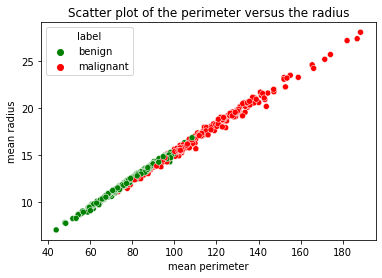

In [21]:
# Plot the perimeter versus the radius 
sns.scatterplot(x=df['mean perimeter'], y=df['mean radius'], hue=df['label'],palette=color_dict)
plt.title('Scatter plot of the perimeter versus the radius')

<font color='blue'> 

- Visually, we can see a important relationship between these two features.

- Visually, we could use these two labels to make the difference between healthy and malignant breast cells, but we will have some errors at some point. We can see that when mean perimeter is included into [80;120], we can't determine very well the difference.
</font>

## b) Circle fitting using linear regression on cells' features

We will now assess more rigoroulsy the circularity of the breast cells from the Winsconsin dataset, using linear regression. More precisely, we look for a relationship between the perimeter $p$ and the radius $r$: 

<center>$p = \alpha * r + \beta$ </center>

<font color='blue'> Question 5: supposing breast cells are circular, what are the expected values for $\alpha$ and  $\beta$? </font>

<font color='blue'>  
We know that the formula for the perimeter of a circle is: p = 2*pi*r, with r the radius of this circle.
    
Initially, supposing breast cells are circular, 𝛼 would be equal to 2*pi and 𝛽 to 0. 
</font>

 We will now focus on linear regression. For simplification, we will first first suppose that $\beta=0$. The loss to minimize, we call L1, is then written:
 
 $\displaystyle \frac{1}{n} \sum_{i=1}^n (p_i - (\alpha * r_i)) ^ 2$ 
 
 with $n$ the number of samples in the dataset, $p_i$ the perimeter of sample $i$ and $r_i$ the radius of this same sample. This loss, actually the Mean Squared Error (MSE) of the predicted perimeter with respect to the measured perimeter, will be optimized using a classic gradient descent.

<font color='blue'> Question 6: complete the following function to perform linear regression on loss L1 using gradient descent. </font>

In [56]:
# First version of a linear regression using gradient descent
def linear_regression(p1, p2, lr, nb_its, alpha0):   
    
    """
    Linear regression between two input variables p1 and p2, so that p1 = alpha * p2 
    with alpha the parameter to optimize
    
    
    Parameters
    ----------
    p1: vector
        the vector containing the first variable values
    p2: vector
        the vector containing the second variable values
    lr : float
        the learning rate
    nb_its : strictly positive integer
        the number of iterations
    alpha0: float
        the initial alpha value
        
    Returns
    -------
    alpha: float
        the optimized parameter value
    losses: vector of floats
        the vector of loss values over the iterations
        
    Command:
    alpha, losses = linear_regression(p1, p2, lr, nb_its, alpha0)
    
    """

    #Initialize the loss vector
    losses = []
    
    #Initialize the alpha value
    alpha = alpha0
    
    # Perform Gradient Descent 
    for i in range(nb_its): 
        
        #Compute the partial derivative of the loss with respect to alpha 
        d_alpha = np.mean(-2*p1*p2+2*alpha*p2**2)
        
        # Update the alpha value
        alpha = alpha-lr*d_alpha
        
        # Compute the updated L1 loss value
        loss_val = (1/len(p1))*np.sum((p1-(alpha*p2))**2)
        
        # Update the vector of losses
        losses.append(loss_val)
    
    return alpha, losses    

<font color='blue'> Question 7: for each distinct label value, complete the following code to perform linear regression on loss L1 using gradient descent:
- Initialize the process using the expected value of $\alpha$, and display the initial value of the loss L1.
- Perform gradient descent using the L1 loss function, with a learning rate equal to 0.001 and 100 iterations
- Display the optimized alpha and the final L1 loss value
- Superimpose the optimized line on the figure of the perimeter in function of the radius
</font>

In [37]:
labels = np.unique(df.label)
labels

array(['benign', 'malignant'], dtype=object)

Linear regression on benign cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 4.320215995692195
The final alpha is: 6.43162179471489
The final loss value is: 0.9997976094672043


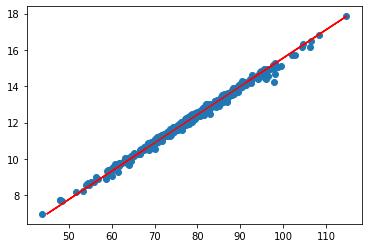

Linear regression on malignant cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 38.93427064426372
The final alpha is: 6.612258213059991
The final loss value is: 4.805110085338103


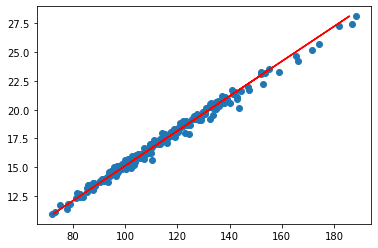

In [176]:
# Learning rate
lr = 0.001

# Set the number of iterations
nb_its = 100

#Select the feature names
feat1, feat2 = 'mean radius','mean perimeter'

#Initialize the dictionary of label losses
losses = {}

#Go through each label
for label in labels:
    print('Linear regression on {0} cells:'.format(label))
    
    # Restrict the dataframe to the samples of the current label
    df_label = df[df['label']==label]
    
    # Get the needed variables for the selected samples
    r = df_label[feat1].values    
    p = df_label[feat2].values 
    
    # Initialize the alpha value
    alpha0 = 2*np.pi
    
    # Display the initial alpha and loss values
    print("The initial value of alpha is:", alpha0)
    loss_initial = (1/len(p))*np.sum((p-(alpha0*r))**2)
    print("The initial value of loss value is:",loss_initial)
    
    # Perform Gradient Descent 
    alpha, label_loss = linear_regression(p1=p, p2=r, lr=lr, nb_its=nb_its, alpha0=alpha0)
    #Update the loss dictionary
    losses[label] = label_loss  
    
    # Display the final alpha and loss value
    print("The final alpha is:",alpha)
    print("The final loss value is:",label_loss[-1])
    # Display the results
    fig, ax = plt.subplots()
    ax.scatter(p, r)
    y=r
    x=alpha*r
    ax.plot(x,y,c='r')
    plt.show()

<font color='blue'> Question 8: visually and quantitatively assess the performances of the algorithm for both labels.
- Did the algorithm work?
- Is there a difference in circularity between malignant and benign cells?
</font>

<font color='blue'> 

- We can see that the algorithm work, visually, the line seems to follow the trend of the scatterplot.
    
- We can see that the formula of a benign cell (p=6.6*r+0.99) is closer to the formula of the perimeter of a circle than the formula of a malignant cell (p=6.6*r+4.8). The circularity of these two kinds of cells is different.

</font>

We will now assess the convergence of the algorithm displaying the evolution of the loss iver iterations.

<font color='blue'> Question 9: Display the evolution of the loss for both labels. Did the algorithm converged to a minimal loss value ?
</font>

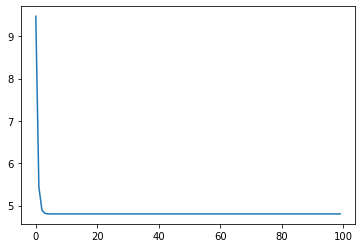

In [91]:
plt.plot(label_loss)

<font color='blue'> 
We can see that the algorithm converge quickly to a minimal loss value. We maybe don't need 100 iterations but 10.
</font>

As we saw in the course, we have a crucial parameter: the learning rate. We will now assess its influence.

<font color='blue'> Question 10: repeat question 7, testing three different values for the learning rate (0.01, 0.001 and 0.0001). Was the choice we did for this parameter in question 7 appropriated?
</font>

Learning rate = 0.01
Linear regression on benign cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 4.320215995692195
The final alpha is: -3.77764244904033e+29
The final loss value is: 2.1505679623477735e+61


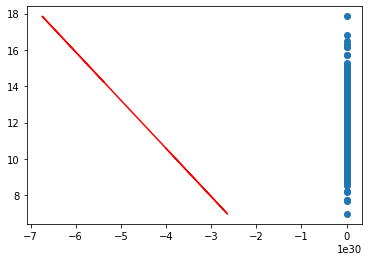

Linear regression on malignant cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 38.93427064426372
The final alpha is: -9.382367737162347e+71
The final loss value is: 2.7743819849433768e+146


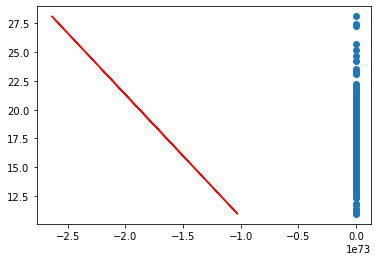

Learning rate = 0.001
Linear regression on benign cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 4.320215995692195
The final alpha is: 6.43162179471489
The final loss value is: 0.9997976094672043


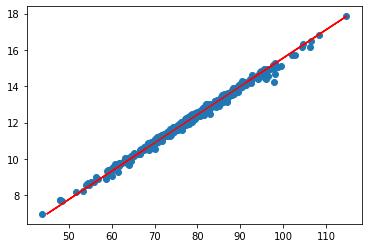

Linear regression on malignant cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 38.93427064426372
The final alpha is: 6.612258213059991
The final loss value is: 4.805110085338103


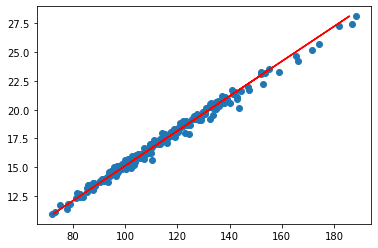

Learning rate = 0.0001
Linear regression on benign cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 4.320215995692195
The final alpha is: 6.4246643300655455
The final loss value is: 1.0070924111340778


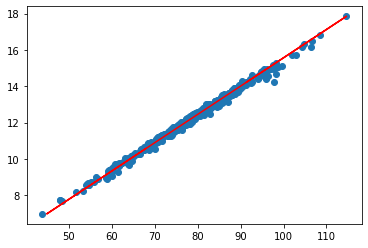

Linear regression on malignant cells:
The initial value of alpha is: 6.283185307179586
The initial value of loss value is: 38.93427064426372
The final alpha is: 6.61176877361184
The final loss value is: 4.805185584006858


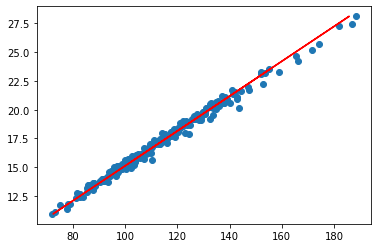

In [177]:
# Set the number of iterations
nb_its = 100 

#Select the feature names
feat1, feat2 = 'mean radius','mean perimeter'
    
# Learning rate
for lr in [0.01,0.001,0.0001]:
    print('Learning rate = {0}'.format(lr))
    
    #Go through each label
    for label in labels:
        print('Linear regression on {0} cells:'.format(label))

        # Restrict the dataframe to the samples of the current label
        df_label = df[df['label']==label]

        # Get the needed variables for the selected samples
        r = df_label[feat1].values    
        p = df_label[feat2].values 

        # Initialize the alpha parameter
        alpha0 = 2*np.pi
        
        #Display the initial alpha and loss values
        print("The initial value of alpha is:", alpha0)
        loss_initial = (1/len(p))*np.sum((p-(alpha0*r))**2)
        print("The initial value of loss value is:",loss_initial)
        
        # Perform Gradient Descent 
        alpha, label_loss = linear_regression(p1=p, p2=r, lr=lr, nb_its=nb_its, alpha0=alpha0)

        # Display the final alpha and loss value
        print("The final alpha is:",alpha)
        print("The final loss value is:",label_loss[-1])
        # Display the results
        fig, ax = plt.subplots()
        ax.scatter(p, r)
        y=r
        x=alpha*r
        ax.plot(x,y,c='r')
        plt.show()

<font color='blue'> 
We can see that for lr = 0.01, the resutls are really bad and high. 
And for lr = 0.0001, results are similar, but it takes too much time relative to 0.001.
So our initial lr = 0.001 was the right one.
</font>

# II. Quadratic regression on breast cells' features using conjugate gradient methods

## a) Visualization of the area and radius features

We will now see if we can obtain the same result using another geometric feature and algorithm. For example, we suppose that if a cell is circular, we should have a quadratic relationship between its area and its radius. We will first visually check that assumption.

<font color='blue'> Question 11: 
- Plot the area values in function of the radius values. Use the "color_dict" dictionary to color the plotted points with the color of the associated label.
- Visually, is there a linear relationship between these two features? 
- Visually, could you use these two labels alone to make the difference between healthy and malignant breast cells?</font>

Text(0.5, 1.0, 'Scatter plot of the area versus the radius')

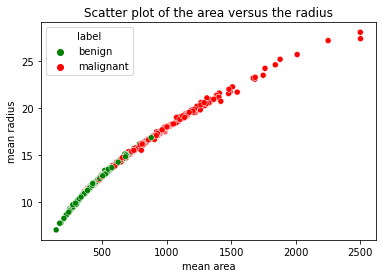

In [113]:
sns.scatterplot(x=df['mean area'], y=df['mean radius'], hue=df['label'],palette=color_dict)
plt.title('Scatter plot of the area versus the radius')

<font color='blue'> 

- Visually we can see that there is a relationship between these two features but not linear.
    
- Visually, we could use these two labels to make the difference between healthy and malignant breast cells, but we will have some errors at some point (around [500;1000]).

</font>

## b) Circle fitting using quadratic regression on cells' features

We will now assess more rigoroulsy the circularity of the breast cells from the Winsconsin dataset, using quadratic regression. More precisely, we look for a relationship between the area $a$ and the radius $r$: 

<center>$a = \alpha * r^2 + \beta * r + \gamma $ </center>

<font color='blue'> Question 12: if the cells are circular, what are the expected values of $\alpha$, $\beta$ and $\gamma$ ? </font>

<font color='blue'> 

We know that the formula for the area of a circle is: p = pi*r^2, with r the radius of this circle.
Initially, supposing breast cells are circular, 𝛼 would be equal to pi and 𝛽 to 0, 𝛾 to 0.
</font>

Without making any simplification, we will now minimize the following loss we call L2:

 $\displaystyle \frac{1}{n} \sum_{x=1}^n (a_i - (\alpha * r_i^2 + \beta * r_i + \gamma)) ^ 2$
 
 with $n$ the number of samples in the dataset, $a_i$ the area of sample $i$ and $r_i$ the radius of this same sample. We will now optimize this loss, but first we need to implement it.

<font color='blue'> Question 13: complete the function implementing the loss L2. </font>

In [232]:
def L2_loss(x, args):

    """
    Loss function used in a quadratic regression between two input variables p1 and p2,
    so that p1 = alpha * p2 ** 2 + beta * p2 + gamma
    with alpha, beta and gamma the parameters to optimize
    
    Parameters
    ----------
    x: 3-vector
        the vector containing the alpha, beta and gamma values
    p1: vector
        the vector containing the first variable values
    p2: vector
        the vector containing the second variable values
        
    Returns
    -------
    loss_val: float
        the loss value
        
    Command:
    loss_val = L2_loss(x, p1, p2)
    
    """
    p1, p2 = args['p1'],args['p2']
    # Get the input variables
    alpha, beta, gamma = x
    
    #Compute and return the L2 loss value
    loss_val = (1/len(p1))*np.sum((p1-(alpha*(p2**2)+beta*p2+gamma))**2)
    
    return loss_val

<font color='blue'> Question 13: complete the function implementing the partial derivatives of the loss L2 with respect to alpha, beta and gamma. </font>

In [233]:
def L2_der(x, args):

    """
    Partial derivatives of the loss function L2 used in a quadratic regression between two input variables 
    p1 and p2, so that p1 = alpha * p2 ** 2 + beta * p2 + gamma
    with alpha, beta and gamma the parameters to optimize
    
    Parameters
    ----------
    x: 3-vector
        the vector containing the alpha, beta and gamma values
    p1: vector
        the vector containing the first variable values
    p2: vector
        the vector containing the second variable values
        
    Returns
    -------
    loss_der: float
        the 3-vector of partial derivatives
        
    Command:
    loss_der = L2_der(x, p1, p2)
    
    """
    p1, p2 = args['p1'],args['p2']

    # Get the input variables
    alpha, beta, gamma = x
    
    # Compute the partial derivative of L2 with respect to alpha
    d_alpha = np.mean(4*p2*(-p1+alpha*(p2**2)+beta*p2+gamma))
    
    # Compute the partial derivative of L2 with respect to beta
    d_beta = np.mean(-2*p2*(p1-alpha*(p2**2)-beta*p2-gamma))
    
    # Compute the partial derivative of L2 with respect to gamma
    d_gamma = np.mean(2*(p1-alpha*(p2**2)-beta*p2-gamma))
    
    # Return the vector of partial derivatives
    loss_der = np.array([d_alpha, d_beta, d_gamma])
    
    return loss_der

<font color='blue'> Question 14: apply a quadratic regression between the area and radius feature values. As previously, make the distinction between the labels, and perform the following steps:
- Initialize the process using the expected value of $\alpha$, $\beta$ and $\gamma$, display these values and the one of the initial loss L2.
- Apply the conjugate gradient method using the optimize function from the Scipy library, and asociate the "jac" and "args" arguments with the appropriated function or variables. 
- Display the optimized alpha, beta, gamma and L2 final loss values
</font>

In [237]:
# Initialize the vector of variables to optimize
x0 = np.array([np.pi,0,0])

# Display the initial variable values
print("The initial value of alpha is:", x0[0])
print("The initial value of beta is:", x0[1])
print("The initial value of gamma is:", x0[2])

# Features to select
feat1, feat2 = 'mean area','mean radius'

#Go through each label
for label in labels:
    print()
    print('Quadratic regression on {0} cells:'.format(label))

        # Restrict the dataframe to the samples of the current label
    df_label = df[df['label']==label]

        # Get the needed variables for the selected samples
    a = df_label[feat1].values    
    r = df_label[feat2].values 

        # Display the initial loss
    loss_val = (1/len(a))*np.sum((a-(x0[0]*(r**2)+x0[1]*r+x0[2]))**2)
    print('The initial loss is:',loss_val)
    
        # Optimization using conjugate gradient
    additional = {'p1': a, 'p2':r}
    conj_gradient = minimize(method='CG', fun=L2_loss,args=additional, x0=x0, jac=L2_der)

        # Display the final variable values
    print("The final value of alpha is:", optimize.OptimizeResult(conj_gradient).x[0])
    print("The final value of beta is:", optimize.OptimizeResult(conj_gradient).x[1])
    print("The final value of gamma is:", optimize.OptimizeResult(conj_gradient).x[2])

        # Display the final loss value
    print("The final loss value is:", optimize.OptimizeResult(conj_gradient).fun)


The initial value of alpha is: 3.141592653589793
The initial value of beta is: 0.0
The initial value of gamma is: 0.0

Quadratic regression on benign cells:
The initial loss is: 140.1446267318879
The final value of alpha is: 3.075366581134852
The final value of beta is: -0.033113036227470624
The final value of gamma is: 0.002711293071482872
The final loss value is: 26.203138548623443

Quadratic regression on malignant cells:
The initial loss is: 684.1691819607581
The final value of alpha is: 3.1060598043487397
The final value of beta is: -0.01776642462052681
The final value of gamma is: 0.0009886812850929253
The final loss value is: 536.156121107313


<font color='blue'> Question 15: based on the result of the previous question, is there a significative difference in circularity between healthy and pathological cells ? </font>

<font color='blue'> 

Based on the result of the previous question, there is actually a small difference in circularity between healthy and pathological cells. The difference is not significative, but we have a bigger loss value for malignant cells (536.2>26.2)

</font>